# Урок 4. Деревья решений

**1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)**

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn import model_selection

import numpy as np

In [2]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

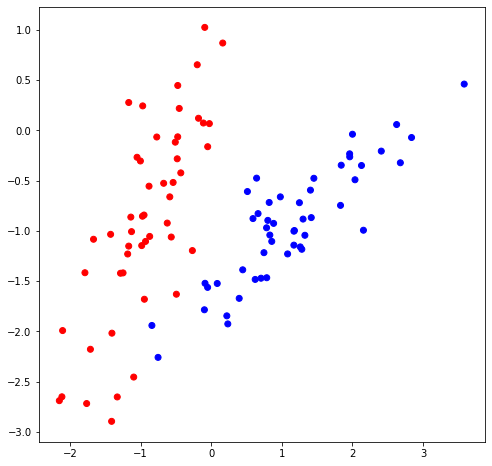

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(classification_data[:, 0], classification_data[:, 1], 
              c=classification_labels, cmap=colors)

In [4]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction 

In [5]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [6]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [7]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [8]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5
    
    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [9]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, max_depth=10):
    return build_tree_internal(data, labels, max_depth)

In [10]:
def build_tree_internal(data, labels, max_depth, depth=0):
    depth += 1

    quality, t, index = find_best_split(data, labels)

    #  прекращаем рекурсию, когда нет прироста в качества или достигнут максимум глубины
    if quality == 0 or depth > max_depth:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree_internal(true_data, true_labels, max_depth, depth)
    false_branch = build_tree_internal(false_data, false_labels, max_depth, depth)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [11]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [12]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [13]:
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [14]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [15]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

In [16]:
# Разобьем выборку на обучающую и тестовую

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [17]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)

In [18]:
# Напечатаем ход нашего дерева
print_tree(my_tree)

Индекс 0
Порог 0.16261402870113306
--> True:
  Индекс 1
  Порог -1.5208896621663803
  --> True:
    Индекс 0
    Порог -0.9478301462477035
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


In [19]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

# Получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [20]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

98.57142857142858

In [21]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

100.0

Text(0.5, 1.0, 'Test accuracy=100.00')

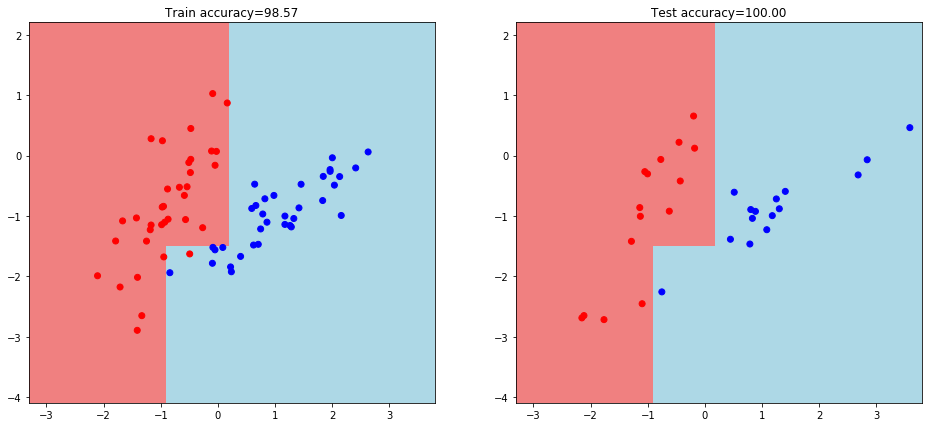

In [22]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')



**2. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.**

In [23]:
# сгенерируем данные
data, target, coef = datasets.make_regression(n_samples=1000, n_features = 5, n_informative = 5, 
                                                 n_targets = 1, noise = 20, coef = True, random_state = 42)

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(data, target,
                                                                                    test_size = 0.3, random_state = 42)

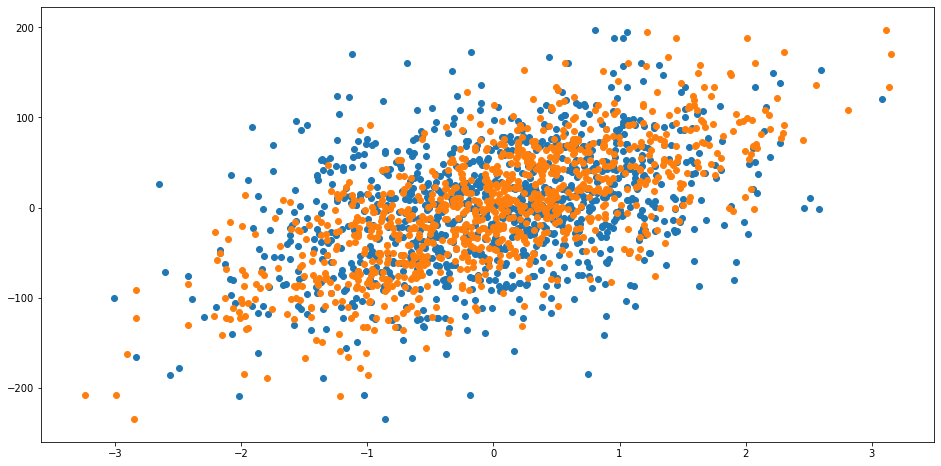

In [24]:
# визуализируем часть сгенерированных данных
plt.figure(figsize=(16, 8))
plt.scatter(data[:, 0], target)
plt.scatter(data[:, 1], target)
plt.show()

In [25]:
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = labels.mean()
    def predict(self):
        prediction = np.mean(self.labels)        
        return prediction

In [26]:
# Расчет качества

def quality(left_labels, right_labels, current_var):
    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    # дисперсия вместо критерия Джини
    return current_var - p * np.var(left_labels) - (1 - p) * np.var(right_labels)

In [27]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5
    
    current_var = np.var(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_var)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [28]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)

In [29]:
# Напечатаем ход нашего дерева
print_tree(my_tree)

Индекс 1
Порог -0.45909031021899177
--> True:
  Индекс 0
  Порог 0.15946250680412918
  --> True:
    Индекс 3
    Порог -0.08268068584269925
    --> True:
      Индекс 1
      Порог -1.1511537365528692
      --> True:
        Индекс 2
        Порог -0.926930471578083
        --> True:
          Прогноз: -175.27381312764942
        --> False:
          Индекс 4
          Порог -0.36920720044744615
          --> True:
            Прогноз: -134.72016207222
          --> False:
            Прогноз: -103.147271508074
      --> False:
        Индекс 4
        Порог 0.15776143929376948
        --> True:
          Индекс 0
          Порог -0.21113023882769444
          --> True:
            Индекс 4
            Порог -0.49757083838520716
            --> True:
              Прогноз: -129.86183286913624
            --> False:
              Прогноз: -105.40568822606954
          --> False:
            Прогноз: -67.02405344992006
        --> False:
          Индекс 0
          Порог -0.51386691733

In [30]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

# Получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [31]:
from sklearn.metrics import r2_score
train_r2_score = r2_score(train_labels, train_answers)
test_r2_score = r2_score(test_labels, answers)

train_r2_score, test_r2_score

(0.8928275790171819, 0.6475725270324315)

In [34]:
# Изучим изменение качества модели от различных значений глубины дерева
train_r2 = []
test_r2 = []
depths = range(1, 15)

for depth in depths:
    my_tree = build_tree(train_data, train_labels, depth)
    
    train_answers = predict(train_data, my_tree)
    answers = predict(test_data, my_tree)
    
    train_r2.append(r2_score(train_labels, train_answers))
    test_r2.append(r2_score(test_labels, answers))

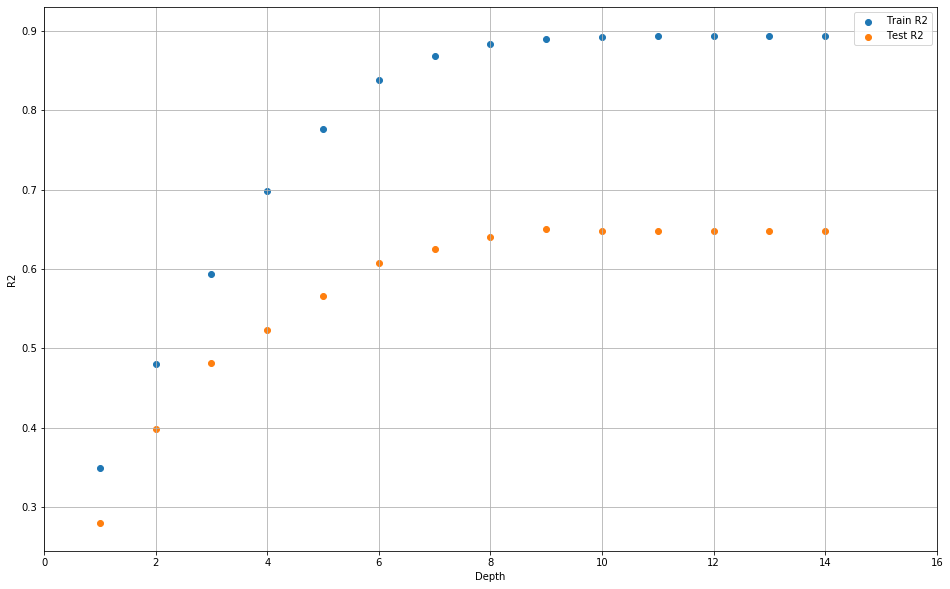

In [35]:
plt.figure(figsize=(16, 10))

plt.scatter(depths, train_r2, label = 'Train R2')
plt.scatter(depths, test_r2, label = 'Test R2')

plt.xlim((0, 16))
plt.xlabel('Depth')
plt.ylabel('R2')
plt.grid(True)
plt.legend()
plt.show()

In [37]:
train_r2[8], test_r2[8]

(0.8901295390885253, 0.6500844221233633)

**Выводы.**

1) Точность модели получилась скверная. Наверное это связано с какой-то моей ошибкой (в функции quality при замене на дисперсию?). Также заметила, что чем проще данные, тем хуже полученное качество. Первая попытка была при n_features=1, этот результат даже отображать не стала, настолько он плох.

2) Лучший результат наблюдается в данном случае при глубине = 9, затем начинается небольшое переобучение

3) Улучшить качество модели можно было, реализовав в задании 1 регулировку дополнительных параметров, не только глубины.